In [1]:
import lightgbm
import numpy as np
import pandas as pd
from feature_engine.datetime import DatetimeFeatures
from lightgbm import LGBMClassifier
from sklearn.compose import make_column_selector
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from src.column_selector import ColumnSelector
from src.date_coercion import DateCoercion
from sklearn.preprocessing import OneHotEncoder
from src.high_cardinality_dropper import HighCardinalityDroppper
from sklearn.impute import SimpleImputer
from src.nan_dropper import NaNColumnsDropper
from src.replacer import Replacer
from sklearn.preprocessing import StandardScaler

## Load data set

In [2]:
car_insurance_df = pd.read_csv("./data/insurance_claims.csv")
car_insurance_df.head()

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported,_c39
0,328,48,521585,2014-10-17,OH,250/500,1000,1406.91,0,466132,...,YES,71610,6510,13020,52080,Saab,92x,2004,Y,NaN
1,228,42,342868,2006-06-27,IN,250/500,2000,1197.22,5000000,468176,...,?,5070,780,780,3510,Mercedes,E400,2007,Y,NaN
2,134,29,687698,2000-09-06,OH,100/300,2000,1413.14,5000000,430632,...,NO,34650,7700,3850,23100,Dodge,RAM,2007,N,NaN
3,256,41,227811,1990-05-25,IL,250/500,2000,1415.74,6000000,608117,...,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y,NaN
4,228,44,367455,2014-06-06,IL,500/1000,1000,1583.91,6000000,610706,...,NO,6500,1300,650,4550,Accura,RSX,2009,N,NaN


In [3]:
train_df, test_df = train_test_split(
    car_insurance_df, test_size=0.2, random_state=42, shuffle=True
)

In [4]:
train_df.head()

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported,_c39
29,241,45,596785,2014-03-04,IL,500/1000,2000,1104.50,0,432211,...,NO,91650,14100,14100,63450,Accura,TL,2011,N,NaN
535,65,23,876699,1999-12-12,OH,250/500,1000,1099.95,0,473109,...,YES,52400,6550,6550,39300,Accura,MDX,2005,Y,NaN
695,289,45,943425,1999-10-28,OH,250/500,2000,1221.41,0,466289,...,NO,2700,300,300,2100,Honda,Accord,2006,N,NaN
557,63,26,550930,1995-10-12,IL,500/1000,500,1500.04,6000000,613826,...,YES,5160,860,860,3440,Accura,TL,2004,N,NaN
836,257,43,797636,1992-05-19,IN,100/300,1000,974.84,0,468984,...,YES,85320,21330,7110,56880,Nissan,Pathfinder,2006,N,NaN


# Columns sets

In [5]:
excluded = [
    "policy_number",
    "insured_hobbies",
    "policy_state",
    "incident_state",
    "incident_city",
    "insured_hobbies",
    "auto_make",
    "auto_model",
]
date_features = ["incident_date", "policy_bind_date"]
target_variable = ["fraud_reported"]

In [6]:
selected_columns = car_insurance_df.columns.difference(
    excluded + target_variable
).tolist()

selected_columns

['_c39',
 'age',
 'authorities_contacted',
 'auto_year',
 'bodily_injuries',
 'capital-gains',
 'capital-loss',
 'collision_type',
 'incident_date',
 'incident_hour_of_the_day',
 'incident_location',
 'incident_severity',
 'incident_type',
 'injury_claim',
 'insured_education_level',
 'insured_occupation',
 'insured_relationship',
 'insured_sex',
 'insured_zip',
 'months_as_customer',
 'number_of_vehicles_involved',
 'police_report_available',
 'policy_annual_premium',
 'policy_bind_date',
 'policy_csl',
 'policy_deductable',
 'property_claim',
 'property_damage',
 'total_claim_amount',
 'umbrella_limit',
 'vehicle_claim',
 'witnesses']

In [7]:
categorical_columns = (
    car_insurance_df.select_dtypes(include=["object"])
    .columns.difference(excluded)
    .tolist()
)
print(categorical_columns)

['authorities_contacted', 'collision_type', 'fraud_reported', 'incident_date', 'incident_location', 'incident_severity', 'incident_type', 'insured_education_level', 'insured_occupation', 'insured_relationship', 'insured_sex', 'police_report_available', 'policy_bind_date', 'policy_csl', 'property_damage']


In [8]:
numeric_columns = (
    car_insurance_df.select_dtypes(include=["int64", "float64"])
    .columns.difference(excluded)
    .tolist()
)
print(numeric_columns)

['_c39', 'age', 'auto_year', 'bodily_injuries', 'capital-gains', 'capital-loss', 'incident_hour_of_the_day', 'injury_claim', 'insured_zip', 'months_as_customer', 'number_of_vehicles_involved', 'policy_annual_premium', 'policy_deductable', 'property_claim', 'total_claim_amount', 'umbrella_limit', 'vehicle_claim', 'witnesses']


# Columns transformers

In [9]:
mapping_dict = dict(
    zip(selected_columns, [{"?": np.nan} for _ in selected_columns])
)

nan_corrector = Replacer(mapper=mapping_dict)
mapping_dict

{'_c39': {'?': nan},
 'age': {'?': nan},
 'authorities_contacted': {'?': nan},
 'auto_year': {'?': nan},
 'bodily_injuries': {'?': nan},
 'capital-gains': {'?': nan},
 'capital-loss': {'?': nan},
 'collision_type': {'?': nan},
 'incident_date': {'?': nan},
 'incident_hour_of_the_day': {'?': nan},
 'incident_location': {'?': nan},
 'incident_severity': {'?': nan},
 'incident_type': {'?': nan},
 'injury_claim': {'?': nan},
 'insured_education_level': {'?': nan},
 'insured_occupation': {'?': nan},
 'insured_relationship': {'?': nan},
 'insured_sex': {'?': nan},
 'insured_zip': {'?': nan},
 'months_as_customer': {'?': nan},
 'number_of_vehicles_involved': {'?': nan},
 'police_report_available': {'?': nan},
 'policy_annual_premium': {'?': nan},
 'policy_bind_date': {'?': nan},
 'policy_csl': {'?': nan},
 'policy_deductable': {'?': nan},
 'property_claim': {'?': nan},
 'property_damage': {'?': nan},
 'total_claim_amount': {'?': nan},
 'umbrella_limit': {'?': nan},
 'vehicle_claim': {'?': nan

In [10]:
column_selector = ColumnSelector(selected_columns=selected_columns)

In [11]:
date_coercion = DateCoercion(date_columns=date_features)

In [12]:
nan_column_dropper = NaNColumnsDropper(threshold=0.4)

In [13]:
high_cardinality_droppper = HighCardinalityDroppper(
    threshold=0.9,
    exclude=date_features,
)

In [14]:
date_featurizer = DatetimeFeatures(
    variables=date_features,
    features_to_extract=["month", "day_of_week", "day_of_month", "day_of_year"]
)

In [15]:
numeric_imputer = SimpleImputer(strategy="median")

In [16]:
categorical_imputer = SimpleImputer(strategy="most_frequent")

In [17]:
numeric_transformer = StandardScaler()

In [18]:
one_hot_transformer = OneHotEncoder(handle_unknown="ignore")

# Data preprocessing steps

In [19]:
data_cleaner = Pipeline(
    steps=[
        ("nan corrector", nan_corrector),
        ("business rules selector", column_selector),
        ("date coercion", date_coercion),
        ("nan column dropper", nan_column_dropper),
        ("high cadrdinality dropper", high_cardinality_droppper),
    ]
)

In [20]:
numeric_transformer = Pipeline(
    steps=[
        ("numerical_imputer", numeric_imputer),
        ("scaler", numeric_transformer),
    ]
)

In [21]:
categorical_transformer = Pipeline(
    steps=[
        ("categorical_imputer", categorical_imputer),
        ("OHE", one_hot_transformer),
    ]
)

In [22]:
column_transformer = ColumnTransformer(
    transformers=[
        ("date_feature", date_featurizer, date_features),
        (
            "categorical_transformer",
            categorical_transformer,
            make_column_selector(dtype_include=object),
        ),
        (
            "numeric_transformer",
            numeric_transformer,
            make_column_selector(dtype_include=[np.float64, np.int64]),
        ),
    ],
)

In [23]:
preprocessor_tester = Pipeline(
    [
        ("cleaner", data_cleaner),
        ("column_transformer", column_transformer),
    ]
)

In [24]:
X_train = train_df.loc[:,train_df.columns.difference(target_variable)]
y_train = train_df.loc[:, target_variable].values.ravel()

X_test = test_df.loc[:,test_df.columns.difference(target_variable)]
y_test = test_df.loc[:, target_variable].values.ravel()

In [25]:
preprocessor_tester.fit(X_train)

Pipeline(steps=[('cleaner',
                 Pipeline(steps=[('nan corrector',
                                  Replacer(mapper={'_c39': {'?': nan},
                                                   'age': {'?': nan},
                                                   'authorities_contacted': {'?': nan},
                                                   'auto_year': {'?': nan},
                                                   'bodily_injuries': {'?': nan},
                                                   'capital-gains': {'?': nan},
                                                   'capital-loss': {'?': nan},
                                                   'collision_type': {'?': nan},
                                                   'incident_date': {'?': nan},
                                                   'incident_hour_of_the_day': {'?': nan},
                                                   'incident_locati...
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('OHE',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x13df37fa0>),
                                                 ('numeric_transformer',
                                                  Pipeline(steps=[('numerical_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x13df37400>)]))])

In [26]:
output_df = preprocessor_tester.fit_transform(X_train)
output_df

array([[ 2.        ,  6.        , 15.        , ..., -0.48930152,
         1.32765371,  0.46537425],
       [ 1.        ,  3.        , 15.        , ..., -0.48930152,
         0.05344995, -1.32023439],
       [ 2.        ,  4.        , 27.        , ..., -0.48930152,
        -1.90929871, -0.42743007],
       ...,
       [ 2.        ,  4.        ,  6.        , ..., -0.48930152,
        -0.04415987,  0.46537425],
       [ 2.        ,  6.        , 15.        , ..., -0.48930152,
         1.07808917, -1.32023439],
       [ 1.        ,  3.        , 29.        , ..., -0.48930152,
        -0.69049511,  1.35817857]])

# Model

In [28]:
preprocessor = Pipeline(
    [
        ("cleaner", data_cleaner),
        ("column_transformer", column_transformer)
    ]
)

In [29]:
classifier = LGBMClassifier(
    class_weight="balanced",
    random_state=11,
    learning_rate=0.03,
    n_estimators=600,
    reg_lambda=0.19,
    reg_alpha=0.19,
)

In [30]:
model = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("classifier", classifier),
    ]
)

In [31]:
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('cleaner',
                                  Pipeline(steps=[('nan corrector',
                                                   Replacer(mapper={'_c39': {'?': nan},
                                                                    'age': {'?': nan},
                                                                    'authorities_contacted': {'?': nan},
                                                                    'auto_year': {'?': nan},
                                                                    'bodily_injuries': {'?': nan},
                                                                    'capital-gains': {'?': nan},
                                                                    'capital-loss': {'?': nan},
                                                                    'collision_type': {'?': nan},
                                                                    'incident_date': {'?': nan},
                                                                    'incident_hour_of_the...
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x13df37fa0>),
                                                                  ('numeric_transformer',
                                                                   Pipeline(steps=[('numerical_imputer',
                                                                                    SimpleImputer(strategy='median')),
                                                                                   ('scaler',
                                                                                    StandardScaler())]),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x13df37400>)]))])),
                ('classifier',
                 LGBMClassifier(class_weight='balanced', learning_rate=0.03,
                                n_estimators=600, random_state=11,
                                reg_alpha=0.19, reg_lambda=0.19))])

# Summary

In [32]:
y_test[:20]

array(['N', 'N', 'N', 'N', 'N', 'N', 'N', 'Y', 'N', 'N', 'N', 'N', 'N',
       'Y', 'Y', 'N', 'N', 'Y', 'Y', 'Y'], dtype=object)

In [33]:
# Accuracy
round(model.score(X_test, y_test), 4)

0.77

In [34]:
# F1 score
from sklearn.metrics import f1_score

round(f1_score(model.predict(X_test), y_test, pos_label="Y"), 4)

0.5818

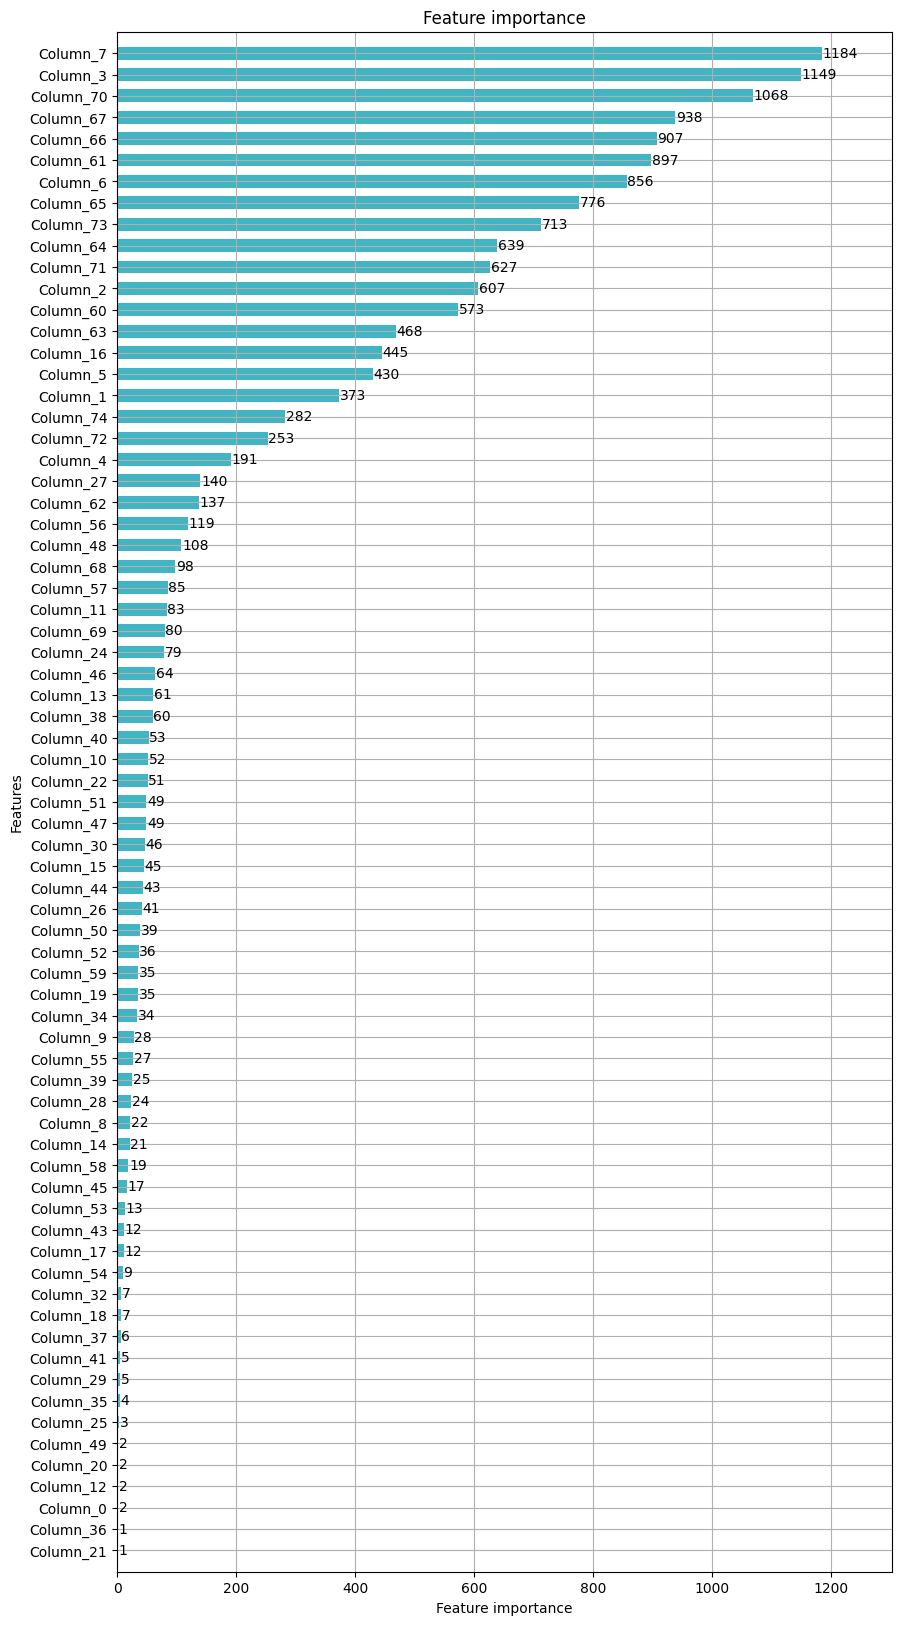

In [36]:
ax = lightgbm.plot_importance(
    model.named_steps["classifier"],
    height=0.6,
    figsize=(10, 20),
    color="#42b5c4",
)